## 🚀 Environment Setup: Prerequisites

Before running the project script or launching a Jupyter Notebook, you **must** configure the following environment variables in your terminal (Mac/Linux) or PowerShell (Windows).

-----

### 1\. W\&B API Key (Required for Experiment Tracking)

You need to set your Weights & Biases (W\&B) API key for logging and tracking your training runs.

```bash
export WANDB_API_KEY="paste_your_wandb_api_key_here"
```

-----

### 2\. AWS Credentials (Required for Local Development)

If you are **NOT** running this code inside a dedicated SageMaker Notebook Instance (which handles credentials automatically), you must configure your AWS access keys and region to allow the script to interact with S3 and the SageMaker API.

```bash
export AWS_ACCESS_KEY_ID="your_aws_key"
export AWS_SECRET_ACCESS_KEY="your_aws_secret"
export AWS_DEFAULT_REGION="us-east-1"  # Replace with your actual region
```

## 🚀 MLOps Configuration Summary

This Python script is an **environment setup** for your machine learning project. It primarily handles three key areas:

### 1. Secret Configuration
* It retrieves your **Weights & Biases (W&B) API Key** (`WANDB_API_KEY`) from the environment, which is used for **experiment tracking**.

---

### 2. Resource Definition
* **S3 Bucket:** Specifies the name of the **S3 bucket** (`sleep-disorder-mlops-bucket`) to store data and models.
* **Code Source:** Defines the **Git Repository URL** where your training code is located.
* **Compute Power:** Sets the **AWS EC2 instance type** (`ml.m5.large`) that SageMaker will use for training.

---

### 3. Paths and Identity
* **AWS Role:** **Automatically obtains** the necessary **AWS execution role** (permissions) for SageMaker jobs.
* **S3 Paths:** **Automatically generates** the specific S3 locations for both **input data** (`S3_INPUT_PATH`) and **model outputs** (`S3_OUTPUT_PATH`).

**In short,** this script acts as a **starter** for your MLOps workflow. It tells AWS SageMaker: **where to find the code** (Git), **what machine to run on** (Instance Type), **which identity to use** (Role), and **where to get data and save results** (S3 Paths).

In [ ]:
import os
import boto3
import sagemaker
from sagemaker import get_execution_role

# ==========================================
# ⚙️ Global Project Configuration
# ==========================================

print("--- 🐢 Initializing Project Configuration ---")

# ------------------------------------------
# 1. Secret Variables (Read from Environment)
# ------------------------------------------
# Must be configured via `export WANDB_API_KEY=xxx` before running
WANDB_API_KEY = os.environ.get("WANDB_API_KEY")

if not WANDB_API_KEY:
    raise ValueError("❌ Error: Environment variable WANDB_API_KEY not detected. Please configure it in the terminal first: export WANDB_API_KEY='...'")
else:
    print("✅ WANDB_API_KEY environment variable detected.")

# ------------------------------------------
# 2. Basic Cloud Resource Configuration (Non-secret, Modifiable)
# ------------------------------------------
# S3 Bucket Name (Ensure this Bucket exists)
BUCKET_NAME = 'sleep-disorder-mlops-bucket' 

# Git Repository URL (Source of Code)
GIT_REPO_URL = 'https://github.com/vinnie071015/sleeping-disorder-mlops.git'
GIT_BRANCH = 'main'

# Training Instance Type
INSTANCE_TYPE = 'ml.m5.large'

# ------------------------------------------
# 3. Automated Identity & Path Generation (Do not modify)
# ------------------------------------------
# Dynamically get AWS Account ID and Role to avoid hardcoding
try:
    # Try to automatically get SageMaker Role
    ROLE = get_execution_role()
except ValueError:
    print("⚠️  Warning: Could not automatically retrieve Role, attempting manual construction...")
    sts = boto3.client('sts')
    _account_id = sts.get_caller_identity()["Account"]
    # Default construction rule, modify if your Role name differs
    ROLE = f"arn:aws:iam::{_account_id}:role/SageMakerExecutionRole"

# Initialize Session
SESSION = sagemaker.Session()

# Auto-construct S3 Paths (Single Source of Truth)
# Input Path: SageMaker downloads data from here
S3_INPUT_PATH = f's3://{BUCKET_NAME}/raw_data/'

# Output Path: SageMaker saves models here
S3_OUTPUT_PATH = f's3://{BUCKET_NAME}/sagemaker-tuning-output/'

print(f"\n✅ Configuration Summary:")
print(f"   - AWS Role: {ROLE}")
print(f"   - S3 Bucket: {BUCKET_NAME}")
print(f"   - Data Source: {S3_INPUT_PATH}")
print(f"   - Model Output: {S3_OUTPUT_PATH}")
print(f"   - Git Repo: {GIT_REPO_URL}")
print("\n--- 🚀 Configuration Complete, Ready to Go ---")

## 🎯 SageMaker Hyperparameter Tuning Setup

This code configures and prepares jobs to run **Hyperparameter Tuning** on **Amazon SageMaker** for three different models: Random Forest, SVM, and Logistic Regression.

---

### 1. Data Input
* **`train_input`:** Defines how SageMaker will read your training data from the designated **S3 path** (`S3_INPUT_PATH`). It specifies the data format as CSV.

---

### 2. Common Estimator Configuration
* **`common_estimator_args`:** This dictionary holds all the shared, fundamental settings needed for *any* training job:
    * **Code:** Points to your training script (`src/train.py`) located in the **Git repository**.
    * **AWS Resources:** Uses the pre-configured **IAM Role**, **Instance Type**, and **S3 Output Path**.
    * **W&B Integration:** Injects the **Weights & Biases** API key for experiment tracking within the training container.

---

### 3. Defining and Launching Tuners
* **`metric_definitions`:** Teaches SageMaker how to read and extract key performance scores (like **`accuracy`** and **`f1`**) from your training script's logs.
* **Tuner Objects:** The script creates three separate **`HyperparameterTuner`** objects:
    * **Random Forest Tuner:** Tunes parameters like `n_estimators` and `max_depth`.
    * **SVM Tuner:** Tunes parameters like `C` and `kernel`.
    * **Logistic Regression Tuner:** Tunes the `C` parameter.

**Key Point:**
Each tuner is set to maximize **`accuracy`** (`objective_metric_name='accuracy'`). The settings (`max_jobs=2, max_parallel_jobs=1`) mean each tuning task will run 2 trials, one at a time.

**Next Step:** The entire tuning process starts when the `.fit(train_input)` method is called on these tuners.



In [ ]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.tuner import IntegerParameter, ContinuousParameter, CategoricalParameter, HyperparameterTuner

# ==========================================
# 🏗️ Step 1: Define Data Input
# ==========================================
# Use the configured S3_INPUT_PATH variable
train_input = sagemaker.inputs.TrainingInput(
    s3_data=S3_INPUT_PATH, 
    content_type='text/csv'
)

# ==========================================
# 🏗️ Step 2: Define Common Estimator Configuration
# ==========================================
common_estimator_args = {
    'entry_point': 'src/train.py',
    'source_dir': '.',
    'role': ROLE,                    # Use config variable
    'instance_count': 1,
    'instance_type': INSTANCE_TYPE,  # Use config variable
    'framework_version': '1.2-1',
    'py_version': 'py3',
    'git_config': {
        'repo': GIT_REPO_URL,        # Use config variable
        'branch': GIT_BRANCH
    },
    'sagemaker_session': SESSION,
    'output_path': S3_OUTPUT_PATH,   # Use config variable
    
    # Inject environment variables into the training container
    'environment': {
        'WANDB_API_KEY': WANDB_API_KEY, # Use config variable
        'WANDB_PROJECT': 'sleep-disorder-mlops', 
        'WANDB_WATCH': 'false' 
    }
}

print("✅ Common estimator arguments assembled.")

# ==========================================
# 🎛️ Step 3: Define and Launch Tuners
# ==========================================

# Define metrics to capture from logs
metric_definitions = [
    {'Name': 'accuracy', 'Regex': '✅ Accuracy: ([0-9\\.]+)'},
    {'Name': 'f1', 'Regex': '✅ F1 Score: ([0-9\\.]+)'}
]

# --- A. Random Forest ---
print("Configuring Random Forest Tuner...")
rf_estimator = SKLearn(**common_estimator_args) 
rf_estimator.set_hyperparameters(model_type='random_forest')

rf_tuner = HyperparameterTuner(
    estimator=rf_estimator,
    objective_metric_name='accuracy',
    metric_definitions=metric_definitions,
    hyperparameter_ranges={
        'n_estimators': IntegerParameter(50, 150),
        'max_depth': IntegerParameter(5, 15)
    },
    max_jobs=2, max_parallel_jobs=1, base_tuning_job_name='rf-tuning'
)

# --- B. SVM ---
print("Configuring SVM Tuner...")
svm_estimator = SKLearn(**common_estimator_args)
svm_estimator.set_hyperparameters(model_type='svm')

svm_tuner = HyperparameterTuner(
    estimator=svm_estimator,
    objective_metric_name='accuracy',
    metric_definitions=metric_definitions,
    hyperparameter_ranges={
        'C': ContinuousParameter(0.1, 5.0),
        'kernel': CategoricalParameter(['rbf', 'linear'])
    },
    max_jobs=2, max_parallel_jobs=1, base_tuning_job_name='svm-tuning'
)

# --- C. Logistic Regression ---
print("Configuring Logistic Regression Tuner...")
lr_estimator = SKLearn(**common_estimator_args)
lr_estimator.set_hyperparameters(model_type='logistic_regression')

lr_tuner = HyperparameterTuner(
    estimator=lr_estimator,
    objective_metric_name='accuracy',
    metric_definitions=metric_definitions,
    hyperparameter_ranges={
        'C': ContinuousParameter(0.1, 5.0)
    },
    max_jobs=2, max_parallel_jobs=1, base_tuning_job_name='lr-tuning'
)

print("\n🎉 All Tuners defined! Ready to call .fit() ...")

## ⚙️ Code Functionality Overview

This Python script is designed to **launch in parallel** the three previously configured SageMaker **Hyperparameter Tuning** jobs and provide a **real-time monitoring panel** to track their progress and handle results.

### 1. 🛠️ Helper Functions

These functions are the core logic for interacting with the AWS SageMaker service:

* **`get_tuning_job_status(tuner_obj)`:** Fetches the current status of a tuning job from the AWS API in real time (e.g., `Running`, `Completed`, `Failed`).
* **`fetch_latest_error_log(bucket_name, ...)`:** **Called upon failure**. It connects to the S3 bucket, automatically retrieves, and prints the content of the latest debug log file to help with failure diagnosis.
* **`print_best_model_info(tuner_obj, model_name)`:** **Called upon success**. It queries the completed tuning job, finds the **best-performing** training run, and prints that model's highest **Accuracy** score and its **S3 storage path**.

---

### 2. 🚀 Main Flow: Parallel Launch

* By calling **`.fit(..., wait=False)`** on the three tuner objects (`rf_tuner`, `svm_tuner`, `lr_tuner`), the script **simultaneously submits** all three hyperparameter tuning tasks to the AWS SageMaker service.
* The `wait=False` argument is crucial for **parallelism**, allowing the Python script to continue immediately to the monitoring loop without waiting for the jobs to finish.

---

### 3. 🕵️ Real-time Monitoring Loop

* The code enters a **`while True`** loop that refreshes every **30 seconds** (`time.sleep(30)`).
* It prints a clear **tabular dashboard** showing the current status of all three models.
* **Result Handling:** When any task status changes to `Completed`, `Failed`, or `Stopped`:
    * If **`Completed`**, it calls `print_best_model_info` to report the best model's S3 path and score.
    * If **`Failed`**, it calls `fetch_latest_error_log` to automatically retrieve and display the error log for debugging.
* Once all three jobs are processed, the loop exits.

**In summary:** This is a robust script used to **launch**, **monitor**, and automatically **collect results or diagnose failures** for multiple SageMaker tuning jobs running in parallel.


In [ ]:
import boto3
import time
from datetime import datetime
import sagemaker

# ==========================================
# 🛠️ Helper function definitions (Bug fixed)
# ==========================================

def get_tuning_job_status(tuner_obj):
    """Get the status of the current Job from the Tuner"""
    try:
        job_name = tuner_obj.latest_tuning_job.name
        response = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=job_name)
        return response['HyperParameterTuningJobStatus']
    except Exception:
        return "Initializing"

def fetch_latest_error_log(bucket_name, prefix="debug_logs/"):
    """[Call on failure] Retrieve the latest debug log generated from S3 and print it"""
    print(f"\n🔍 [Automatic Diagnosis] Failure detected, retrieving latest log from s3://{bucket_name}/{prefix}...")
    s3 = boto3.client('s3')
    try:
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        if 'Contents' not in response:
            print("⚠️ No log file found in S3.")
            return
        files = sorted(response['Contents'], key=lambda x: x['LastModified'])
        latest_file = files[-1]
        key = latest_file['Key']
        print(f"📄 Latest log found: {key} (Time: {latest_file['LastModified']})")
        print("="*60)
        file_obj = s3.get_object(Bucket=bucket_name, Key=key)
        print(file_obj['Body'].read().decode('utf-8')) 
        print("="*60)
    except Exception as e:
        print(f"❌ Failed to retrieve log: {e}")

def print_best_model_info(tuner_obj, model_name):
    """
    [Call on success] Retrieve and print the S3 path of the best model
    (Fixed the issue with 'str' object has no attribute 'describe')
    """
    try:
        # 1. Get the name of the best Job
        best_job_name = tuner_obj.best_training_job()
        
        if not best_job_name:
            print(f"⚠️ {model_name}: Task showed completion, but no best Training Job was found.")
            return

        # 2. Use boto3 to query Job details directly (This is the most robust method)
        sm_client = boto3.client('sagemaker')
        desc = sm_client.describe_training_job(TrainingJobName=best_job_name)
        
        # 3. Extract metrics
        metrics = desc.get('FinalMetricDataList', [])
        # Find the Accuracy metric
        score = "N/A"
        for m in metrics:
            if m['MetricName'] == 'accuracy':
                score = m['Value']
                break
        
        # 4. Extract S3 path
        s3_uri = desc['ModelArtifacts']['S3ModelArtifacts']
        
        print(f"\n🏆 {model_name} Training Completed!")
        print(f"   ✅ Best Accuracy: {score}")
        print(f"   💾 Best Model Save Location: {s3_uri}")
        
    except Exception as e:
        print(f"⚠️ Failed to get {model_name} model information: {e}")

# ==========================================
# 🚀 Main flow: Parallel launch
# ==========================================

print("\n--- 🚀 Step 5: Launching All Tuning Jobs in Parallel (Smart Monitor V2) ---")
print(f"🕒 Start Time: {datetime.now().strftime('%H:%M:%S')}\n")

# ⚠️ If you don't want to retrain, please comment out the following three fit lines
# ⚠️ Run the monitoring loop below directly, it will capture the status of the tasks that have already finished
rf_tuner.fit({'train': train_input}, wait=False) 
svm_tuner.fit({'train': train_input}, wait=False)
lr_tuner.fit({'train': train_input}, wait=False)

print("✅ All tasks are running in parallel in the cloud (or are already running)! Starting smart monitoring panel...\n")
print("-" * 90)
print(f"{'Time':<10} | {'Random Forest':<20} | {'SVM':<20} | {'Logistic Regression':<20}")
print("-" * 90)

# ==========================================
# 🕵️ Real-time monitoring loop (Includes result handling)
# ==========================================

processed_jobs = {'RF': False, 'SVM': False, 'LR': False}

try:
    while True:
        # 1. Get latest status
        rf_st = get_tuning_job_status(rf_tuner)
        svm_st = get_tuning_job_status(svm_tuner)
        lr_st = get_tuning_job_status(lr_tuner)
        
        current_time = datetime.now().strftime('%H:%M:%S')
        print(f"{current_time:<10} | {rf_st:<20} | {svm_st:<20} | {lr_st:<20}")
        
        # 2. Check RF results
        if rf_st in ['Completed', 'Failed', 'Stopped'] and not processed_jobs['RF']:
            if rf_st == 'Completed':
                print_best_model_info(rf_tuner, "Random Forest")
            elif rf_st == 'Failed':
                print(f"\n❌ Random Forest Task Failed!")
                fetch_latest_error_log(LOG_BUCKET_NAME) # Use the bucket name variable defined earlier
            processed_jobs['RF'] = True 

        # 3. Check SVM results
        if svm_st in ['Completed', 'Failed', 'Stopped'] and not processed_jobs['SVM']:
            if svm_st == 'Completed':
                print_best_model_info(svm_tuner, "SVM")
            elif svm_st == 'Failed':
                print(f"\n❌ SVM Task Failed!")
                fetch_latest_error_log(LOG_BUCKET_NAME)
            processed_jobs['SVM'] = True

        # 4. Check LR results
        if lr_st in ['Completed', 'Failed', 'Stopped'] and not processed_jobs['LR']:
            if lr_st == 'Completed':
                print_best_model_info(lr_tuner, "Logistic Regression")
            elif lr_st == 'Failed':
                print(f"\n❌ Logistic Regression Task Failed!")
                fetch_latest_error_log(LOG_BUCKET_NAME)
            processed_jobs['LR'] = True

        # 5. Exit condition
        if all(processed_jobs.values()):
            print("-" * 90)
            print("\n🎉 All hyperparameter tuning tasks have finished!")
            break
            
        time.sleep(30) 

except KeyboardInterrupt:
    print("\n⚠️ Monitoring manually stopped.")


## 📊 Final Report Code Functionality Overview

### 🛠️ Core Function: `print_best_model_info_fixed`

This function is specialized to retrieve the detailed information about the **best training job** from a completed Hyperparameter Tuner:

1.  **Get Best Job Name (`best_job_name`):**
    * It uses the tuner object's **`.best_training_job()`** method to find the AWS name (a string) of the specific training job that achieved the highest objective score among all trials.

2.  **Query Job Details (`sm_client.describe_training_job`):**
    * It uses the `boto3` SageMaker client to query the AWS service for all details related to that best job name. This is the **key fix** as the tuner object itself doesn't contain all granular training job details.

3.  **Extract Accuracy Score (`score`):**
    * It looks into the job details, specifically the **`FinalMetricDataList`**, to find the value of the metric named **`accuracy`**, which is reported as the final performance score.

4.  **Extract S3 Model Path (`s3_uri`):**
    * It extracts the **`ModelArtifacts`** section from the job details to get the complete S3 path where the best model file is stored, which is necessary for deployment or download.

### 🚀 Running the Final Report

* The code concludes by calling this function three times against the previously defined tuner objects (`rf_tuner`, `svm_tuner`, and `lr_tuner`).
* As long as these tuner objects (even after the jobs have finished) are still in memory, the code can connect to AWS, retrieve their historical best results, and generate a **clear performance summary**.

**In summary:** This is the **closing and auditing step**, used to confirm which model performed best and to retrieve the exact location of its model artifact for the next MLOps stage (like deployment).


In [ ]:
import boto3

def print_best_model_info_fixed(tuner_obj, model_name):
    try:
        # 1. Get the name of the best Job (This is a string)
        best_job_name = tuner_obj.best_training_job()
        
        if not best_job_name:
            print(f"⚠️ {model_name}: No best Training Job found (The task may not be completed or all failed).")
            return

        # 2. Use boto3 to query details (Key fix)
        sm_client = boto3.client('sagemaker')
        desc = sm_client.describe_training_job(TrainingJobName=best_job_name)
        
        # 3. Extract accuracy
        metrics = desc.get('FinalMetricDataList', [])
        score = "N/A"
        for m in metrics:
            if m['MetricName'] == 'accuracy': # Ensure this matches the metric name you defined
                score = m['Value']
                break
        
        # 4. Extract S3 Model Path
        s3_uri = desc['ModelArtifacts']['S3ModelArtifacts']
        
        print(f"\n🏆 {model_name} Result Report")
        print(f"   🔹 Best Job Name: {best_job_name}")
        print(f"   ✅ Best Accuracy: {score}")
        print(f"   💾 Model Download Link: {s3_uri}")
        
    except Exception as e:
        print(f"❌ Failed to retrieve {model_name} information: {e}")

# ==========================================
# Run Remedial Report
# ==========================================
print("--- 📊 Final Scorecard (Extracted from Completed Jobs) ---")

# As long as your tuner object is still in memory, this code will work
print_best_model_info_fixed(rf_tuner, "Random Forest")
print_best_model_info_fixed(svm_tuner, "SVM")
print_best_model_info_fixed(lr_tuner, "Logistic Regression")


### 1. Champion Job Analysis (`analyze_best_job`)

This function focuses on inspecting the environment and configuration used when the model was trained on **Amazon SageMaker**:

* **Job Details Query:** It uses `boto3` to call the `describe_training_job` API, retrieving all metadata for the training job specified by `BEST_JOB_NAME`.
* **Extract Hyperparameters (Secret Sauce):** It prints the exact **hyperparameters** (e.g., the SVM's `C` and `kernel` values) that were used to train this best model. These are the optimal settings found by the tuning process.
* **Extract Training Image:** It prints the **Docker container image URI** (`image_uri`) used to run the training code. This is crucial for **reproducibility**, ensuring consistency between the training and production environments.

---

### 2. Model Download and Local Test (`download_and_test_model`)

This function brings the cloud-stored model artifact down to the local machine for verification:

* **Download:** It uses the SageMaker SDK's `S3Downloader` to fetch the model artifact (a compressed file named `model.tar.gz`) from the specified **S3 URI** to the current directory.
* **Extract:** The model package is extracted into a local directory (`./best_model_extracted`). The artifact inside is typically a serialized Scikit-learn Pipeline object named **`model.joblib`**.
* **Model Loading (Sanity Check):** It uses **`joblib.load`** (a common tool for Scikit-learn serialization) to load the `model.joblib` file into memory.
* **Verification:** Upon successful loading, it prints the **Pipeline structure** and the **specific parameters of the SVM classifier**. This step confirms two things:
    1.  The model file is intact and loadable.
    2.  The loaded model correctly contains the **best hyperparameters** found during tuning. 

**In summary:** This script is a **critical step in the MLOps process**. It extracts the **Model Knowledge** (hyperparameters, environment) and the **Model Asset** (`.tar.gz` file) from the cloud, preparing them for the next stage, typically model deployment.


In [ ]:
import boto3
import sagemaker
import os
import joblib
import tarfile
import shutil

# Set the champion model for in-depth analysis (SVM is chosen here because it has the highest accuracy)
BEST_JOB_NAME = "svm-tuning-251203-2103-002-c8ccdacc" 
MODEL_S3_URI = "s3://sleep-disorder-mlops-bucket/sagemaker-tuning-output/svm-tuning-251203-2103-002-c8ccdacc/output/model.tar.gz"

def analyze_best_job(job_name):
    print(f"\n--- 🕵️‍♀️ Analyzing Champion Job: {job_name} ---")
    
    client = boto3.client('sagemaker')
    desc = client.describe_training_job(TrainingJobName=job_name)
    
    # 1. Extract hyperparameters
    print("\n✅ Best Hyperparameter Configuration (Secret Sauce):")
    hps = desc['HyperParameters']
    for k, v in hps.items():
        # Clean up extra quotes for readability
        clean_v = v.replace('"', '')
        print(f"   - {k}: {clean_v}")
        
    # 2. Extract environment used
    image_uri = desc['AlgorithmSpecification']['TrainingImage']
    print(f"\n✅ Training Image: {image_uri}")
    
    return desc

def download_and_test_model(s3_uri):
    print(f"\n--- ⬇️ Downloading Model for Local Verification ---")
    
    local_tar = "best_model.tar.gz"
    extract_dir = "./best_model_extracted"
    
    # Clean up old files
    if os.path.exists(extract_dir):
        shutil.rmtree(extract_dir)
    
    # 1. Download
    sagemaker.s3.S3Downloader.download(s3_uri, ".")
    print(f"✅ Model compressed package downloaded: {local_tar}")
    
    # Rename the downloaded file (S3Downloader usually keeps the original name, but here we ensure the names match)
    # Note: sagemaker download downloads to the current directory, the file name is model.tar.gz
    # If model.tar.gz already exists in the current directory, it will be overwritten
    
    # 2. Extract
    with tarfile.open("model.tar.gz", "r:gz") as tar:
        tar.extractall(path=extract_dir)
        print(f"✅ Extraction complete, directory contents: {os.listdir(extract_dir)}")
        
    # 3. Load Model (Sanity Check)
    try:
        model_path = os.path.join(extract_dir, "model.joblib")
        pipeline = joblib.load(model_path)
        print("\n🎉 Model loaded successfully!")
        print(f"   - Pipeline Structure: {pipeline}")
        
        # Print the specific parameters of the SVM for double confirmation
        if 'classifier' in pipeline.named_steps:
            clf = pipeline.named_steps['classifier']
            print(f"   - Classifier Parameters: {clf.get_params()}")
            
    except Exception as e:
        print(f"❌ Model loading failed: {e}")

if __name__ == "__main__":
    # 1. Analyze parameters
    analyze_best_job(BEST_JOB_NAME)
    
    # 2. Download and test
    download_and_test_model(MODEL_S3_URI)

## 📊 Final Evaluation and Audit Overview

The code performs three main sections of analysis on the model's performance against the **test dataset**.

---

### 1. Setup and Data Preparation

* **Model Loading:** It safely loads the **optimized Scikit-learn Pipeline (`model.joblib`)** and the **`label_encoder.joblib`** from the `./best_model_extracted` folder (downloaded in the previous step).
* **Data Replication:** It re-loads, cleans, and encodes the original data, then performs the **exact same 80/20 train/test split (using `random_state=42`)** as was used during training. This is essential to ensure a fair evaluation on the held-out **Test Set** (`X_test`, `y_test`).
* **Prediction:** It generates predictions (`y_pred`) using the loaded champion model on the test features.

---

### 2. Performance Metrics & Visualization

This section focuses on the model's raw predictive performance:

* **A. Detailed Classification Report:** Prints the standard **`classification_report`**, showing key metrics like **Precision, Recall, and F1-Score** for *each* target class (`None`, `Insomnia`, `Sleep Apnea`).
* **B. Confusion Matrix:** Generates a **heatmap visualization** of the **Confusion Matrix** 

[Image of a Confusion Matrix Heatmap]
. This plot visually shows:
    * **True Positives:** Values on the main diagonal (correct predictions).
    * **Misclassifications:** Values off the diagonal (e.g., how many "Insomnia" cases were wrongly predicted as "None").

---

### 3. Bias Audit (Fairness Check)

This section assesses the model's fairness, specifically looking for **disparate impact** based on the **`Gender`** feature:

* **Accuracy by Gender:** It calculates and prints the **Accuracy Score** separately for each gender group present in the test set.
* **Bias Plot:** It creates a **bar plot**  that compares the accuracy for each gender against the overall model accuracy (the dashed red line).
* **Conclusion:** The goal is to see if the model performs significantly worse for one gender group compared to another. If the bars are roughly equal in height, the model demonstrates **fairness** regarding the gender attribute.


--- 🏁 Starting Final Evaluation & Audit ---
🔄 Loading model and encoder from ./best_model_extracted...
✅ Model loaded successfully.
--- INFO: Loading data from ../data/Sleep_health_and_lifestyle_dataset.csv ---
--- INFO: Data loaded. Shape: (374, 13) ---
--- DEBUG: Columns standardized. ---
--- DEBUG: Imputing 8 numerical features (Median) ---
--- DEBUG: Imputing 5 categorical features ('Missing') ---
--- DEBUG: BMI categories normalized. ---
--- INFO: Data cleaning completed. Final shape: (374, 13) ---
🤖 Generating predictions on Test Set...

🏆 SECTION 1: DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Insomnia       0.78      0.88      0.82        16
     Missing       0.95      0.98      0.97        43
 Sleep Apnea       0.92      0.75      0.83        16

    accuracy                           0.91        75
   macro avg       0.89      0.87      0.87        75
weighted avg       0.91      0.91      0.91        75


📈 SECTION 2: VISUALIZATI

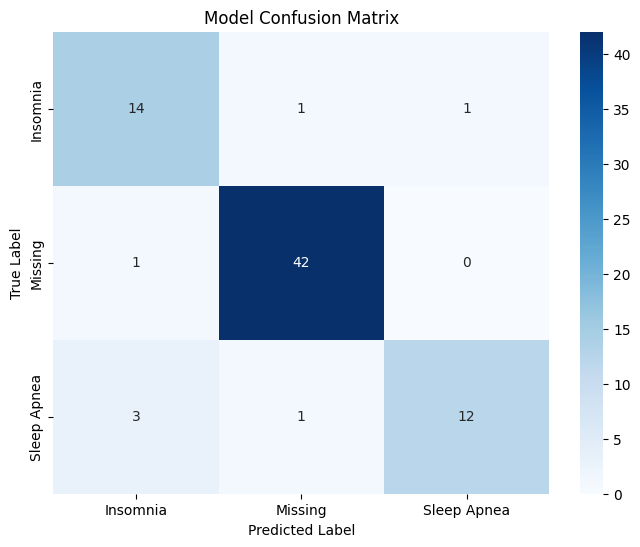

💡 Analysis: Check if the model confuses 'Insomnia' with 'Sleep Apnea'.

⚖️ SECTION 3: BIAS AUDIT (Performance by Gender)
   Gender  Accuracy
0  Female  0.896552
1    Male  0.913043


/var/folders/py/wsw9dv2n5g70rl8sm3pxxjg40000gn/T/ipykernel_21145/2950620417.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender', y='Accuracy', data=bias_summary, palette='viridis')


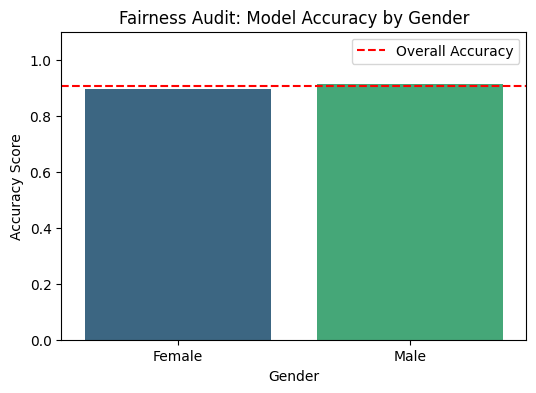

💡 Conclusion: If the bars are roughly equal height, the model is fair regarding gender.


In [2]:
# ==============================================================================
# 📊 FINAL PROJECT REPORT GENERATION (Metrics, Visualization & Bias Audit)
# ==============================================================================
# This cell generates the required plots and metrics for the PDF Report.
# It addresses the "Performance & Evaluation", "Visualization", and "Bias Audit" rubrics.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import sys
import os
import joblib  # <--- Added for loading

# Ensure we can import from src
# Adjust this path if necessary depending on where your notebook is located relative to src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data_processor import load_data, clean_data

print("--- 🏁 Starting Final Evaluation & Audit ---")

# 1. Load Model & Label Encoder (FIX: Explicitly loading them here)
# The previous cell extracted files to './best_model_extracted'
MODEL_DIR = "./best_model_extracted"
MODEL_PATH = os.path.join(MODEL_DIR, "model.joblib")
LE_PATH = os.path.join(MODEL_DIR, "label_encoder.joblib")

if not os.path.exists(MODEL_PATH) or not os.path.exists(LE_PATH):
    print(f"❌ Error: Model files not found in {MODEL_DIR}. Please run the 'download_and_test_model' cell above first.")
else:
    print(f"🔄 Loading model and encoder from {MODEL_DIR}...")
    pipeline = joblib.load(MODEL_PATH)
    label_encoder = joblib.load(LE_PATH)
    print("✅ Model loaded successfully.")

    # 2. Load Data (Replicating the Logic from train.py)
    # Note: Adjust path if your notebook is running from a different directory
    DATA_PATH = "../data/Sleep_health_and_lifestyle_dataset.csv" 
    
    if not os.path.exists(DATA_PATH):
        print(f"⚠️ Warning: Data file not found at {DATA_PATH}. Please check the path.")
    else:
        # Load and Clean
        raw_df = load_data(DATA_PATH)
        df_clean = clean_data(raw_df)
        
        # Encode Target (Consistent with training logic)
        target_col = 'sleep_disorder'
        df_clean[target_col] = df_clean[target_col].fillna('None')
        
        # FIX: Now label_encoder is defined and can be used
        df_clean['target_encoded'] = label_encoder.transform(df_clean[target_col])
        
        # Split Data (Using same seed=42 to strictly reproduce the Test Set used in training)
        X = df_clean.drop(columns=[target_col, 'target_encoded', 'person_id'], errors='ignore')
        y = df_clean['target_encoded']
        
        # 80/20 Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Generate Predictions using the loaded pipeline
        print("🤖 Generating predictions on Test Set...")
        y_pred = pipeline.predict(X_test)
        
        # Get class names for plotting
        class_names = label_encoder.classes_

        # --------------------------------------------------------------------------
        # A. DETAILED METRICS REPORT (Precision, Recall, F1)
        # --------------------------------------------------------------------------
        print("\n" + "="*60)
        print("🏆 SECTION 1: DETAILED CLASSIFICATION REPORT")
        print("="*60)
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        # --------------------------------------------------------------------------
        # B. VISUALIZATION: CONFUSION MATRIX
        # --------------------------------------------------------------------------
        print("\n" + "="*60)
        print("📈 SECTION 2: VISUALIZATION (Confusion Matrix)")
        print("="*60)
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Model Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        print("💡 Analysis: Check if the model confuses 'Insomnia' with 'Sleep Apnea'.")

        # --------------------------------------------------------------------------
        # C. BIAS AUDIT (Fairness Check)
        # --------------------------------------------------------------------------
        print("\n" + "="*60)
        print("⚖️ SECTION 3: BIAS AUDIT (Performance by Gender)")
        print("="*60)
        
        # Recover Gender information for the test set
        # (Note: X_test indices align with df_clean indices)
        audit_df = df_clean.loc[X_test.index].copy()
        audit_df['Correct_Prediction'] = (y_test == y_pred)
        
        # Calculate accuracy per gender
        bias_summary = audit_df.groupby('gender')['Correct_Prediction'].mean().reset_index()
        bias_summary.columns = ['Gender', 'Accuracy']
        
        print(bias_summary)
        
        # Plot Bias
        plt.figure(figsize=(6, 4))
        sns.barplot(x='Gender', y='Accuracy', data=bias_summary, palette='viridis')
        plt.ylim(0, 1.1)
        plt.title('Fairness Audit: Model Accuracy by Gender')
        plt.ylabel('Accuracy Score')
        plt.axhline(y=accuracy_score(y_test, y_pred), color='r', linestyle='--', label='Overall Accuracy')
        plt.legend()
        plt.show()
        
        print("💡 Conclusion: If the bars are roughly equal height, the model is fair regarding gender.")